<center>
    <h1> Natural Language Processing</h1>
    <h2> Style Change Detection </h2>
    <a href="mailto:matteo.donati10@studio.unibo.it">Matteo Donati</a>, <a href="mailto:ildebrando.simeoni@studio.unibo.it">Ildebrando Simeoni</a>, <a href="mailto:diego.biagini2@studio.unibo.it">Diego Biagini</a>
</center>

<br>

This notebook describes a simple but effective
approach for the three Style Change Detection
(SCD) tasks for PAN at CLEF 2022<sup>[[1]](#references)</sup>. The
specific approach we propose is based on finetuning
the BERT transformer and training different
classification heads to solve all three
tasks in an end-to-end fashion.

In particular, to be able to tackle all tasks in a unified manner, we defined some specific architectures there were used to solve all three tasks, using the same pipeline. The specific models are defined as follows:

\begin{array}{ccl}
  \hline
  \text{Model} & \text{Encoder} & \text{Classifier}  \\
  \hline
  m_1^1 & \text{BERT} & \text{Global Max-Pool, FC-2} \\
  m_2^1 & \text{BERT} & \text{Global Avg-Pool, FC-2} \\
  m_3^1 & \text{BERT} & \text{Global Max-Pool, FC-128, FC-2} \\
  m_4^1 & \text{BERT} & \text{$(\text{Conv1D-128, Max-Pool}) \times 3$, Flatten, FC-2} \\
  \hline
\end{array}

Each of the following tasks' sections contain: 1). a data inspection part, in which the specific dataset is retrieved; 2). a data preprocessing part, in which the original dataset is manipulated so to accomodate our needs; 3). models definition and training; 4). model testing; 5). some error analysis (only for task 2 and task 3).

# Libraries

The main libraries are imported. The `transformers` library is used to import the BERT transformer.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 29.4 MB/s 
     |████████████████████████████████| 7.6 MB 59.2 MB/s 
     |████████████████████████████████| 182 kB 81.0 MB/s 


In [ ]:
import os
import pandas as pd
import json
from pandas import json_normalize
import re
from wordcloud import WordCloud, STOPWORDS
import random
import numpy as np
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from transformers import AutoTokenizer, TFAutoModel
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

The SCD-2022 dataset is retrieved and unzipped. In particular, this dataset contains the data for all three tasks. 

In [ ]:
# Mounting Google Drive and unzipping the dataset.
drive.mount("/content/drive")
!unzip /content/drive/MyDrive/pan22.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: dataset3/train/truth-problem-5500.json  
  inflating: dataset3/train/truth-problem-5501.json  
  inflating: dataset3/train/truth-problem-5502.json  
  inflating: dataset3/train/truth-problem-5503.json  
  inflating: dataset3/train/truth-problem-5504.json  
  inflating: dataset3/train/truth-problem-5505.json  
  inflating: dataset3/train/truth-problem-5506.json  
  inflating: dataset3/train/truth-problem-5507.json  
  inflating: dataset3/train/truth-problem-5508.json  
  inflating: dataset3/train/truth-problem-5509.json  
  inflating: dataset3/train/truth-problem-551.json  
  inflating: dataset3/train/truth-problem-5510.json  
  inflating: dataset3/train/truth-problem-5511.json  
  inflating: dataset3/train/truth-problem-5512.json  
  inflating: dataset3/train/truth-problem-5513.json  
  inflating: dataset3/train/truth-problem-5514.json  
  inflating: dataset3/train/truth-problem-5515.json  
  inflating: dataset3/train/truth

#Utility functions

The following cells define all the functions that have been used during the development of this notebook.

In [ ]:
# Sets reproducibility.
def set_reproducibility(seed):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.config.experimental.enable_op_determinism()
  os.environ["PYTHONHASHSEED"] = str(seed)
  os.environ["TF_DETERMINISTIC_OPS"] = "1"
  os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

# Setting seed.
set_reproducibility(seed = 42)

The `create_dataframe` and `data_inspection` functions are used to format the orignal dataset so to create proper dataframes, and to inspect the computed dataframes. In particular, each dataframe is a $N \times 7$ table, where $N$ is the number of documents. Each row of such table is composed of
seven elements: `authors`, the total number of
authors in the generic row (i.e. document); `site`,
the source site from which the document was extracted;
`multi-author`, a boolean flag indicating
whether the generic document has been written
by multiple authors; `changes`, a list of boolean
varibles determining changes between paragraphs
or sentences; `paragraph-authors`, a list of
integer variables that label each paragraph or sentence
with an author ID; `input_text`, the content
of the entire document; `splitted_text`,
the list of paragraphs or sentences of the generic
document.

In [ ]:
def create_dataframe(directory):

  train_set = []
  for filename in os.listdir(directory):
      f = os.path.join(directory, filename)
      if f.endswith('.json'):
            train_set.append(f)

  train_set.sort(key=lambda f: int(re.sub('\D', '', f))) #sorting alphabetically files by name in order to have the correct order

  data = []
  for name in train_set:
    with open(name) as json_data:
      data_dict = json.load(json_data)
      data.append(data_dict)

  df = json_normalize(data)
  
  train_set_text = []
  for filename in os.listdir(directory):
      f = os.path.join(directory, filename)
      if f.endswith('.txt'):
            train_set_text.append(f)

  train_set_text.sort(key=lambda f: int(re.sub('\D', '', f)))

  text_list = []
  for file in train_set_text:
    with open(file) as f:
      content = f.read()
      text_list.append(content)

  df['input_text'] = text_list

  splitted_text = []
  for text in df['input_text']:
    split = text.splitlines()
    splitted_text.append(split)

  df['splitted_text'] = pd.Series(splitted_text)

  #Sanity check, checking if we have splitted correctly (according to the datset) the input text 
  for i in range(len(df.index)):
    if len(df['splitted_text'].iloc[i]) != len(df['paragraph-authors'].iloc[i]):
      print("we have a problem at row: ",i)
    
  return df

In [ ]:
def data_inspection(data, wordCloud : bool = False):  
  print(f"Dataset size: {data.shape}")
  print(f"Dataset columns: {data.columns.values}")
  print(f"Main sources: {data['site'].unique()}")
  print(f"Number of questions per source:\n {data.groupby(['site'])['site'].count()}")
  print(f"Average length of the text: {data['input_text'].apply(len).mean()}") 
  print(f"Possible number of authors: {data['authors'].unique()}") 
  if wordCloud:
    wordcloud = WordCloud(width = 3000, height = 2000, collocations=False, stopwords = STOPWORDS).generate(" ".join(data['input_text'])) 
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud) 
    plt.axis("off");
    plt.show()

The `plot_classes_distribution` is the function that plots the distribution of classes both before and after having performed some data preprocessing.

In [ ]:
# Figures folder.
figures_path = os.path.join(os.getcwd(), "figures")
if not os.path.exists(figures_path): 
  os.makedirs(figures_path)

# Plots classes distribution.
def plot_classes_distribution(classes, counts, filename, figures_path = figures_path):

  # Width of each bar.
  bar_w = 0.45

  # Plot.
  fig, ax = plt.subplots(1, 1, figsize = (4, 4))
  bars = ax.bar(classes[0] - bar_w / 2, counts[0], width = bar_w, label = "Without preprocessing")
  bars = ax.bar(classes[1] + bar_w / 2, counts[1], width = bar_w, label = "With preprocessing")

  # Setting plot attributes.
  ax.set_xlabel("Class")
  ax.set_ylabel("Percentage (%)")
  ax.set_xticks(np.arange(0, len(classes[0]), 1))
  ax.legend()

  fig.savefig(f"{figures_path}/{filename}.pdf", bbox_inches = "tight")
  plt.show()

Data preprocessing is carried out by using the `preprocess_with_data_augmentation` and `preprocess_without_data_augmentation` functions. In particular:

*   `preprocess_with_data_augmentation` creates four tensors (`token_ids`, `attantion_masks`, `token_type_ids`, `labels`) by considering all possible pairs of paragraphs/sentences (namely, by augmenting the original dataset).
*   `preprocess_without_data_augmentation` creates the same four tensors but without applying data augmentation. In this case, the possible pairs of paragraphs/sentences are formed by considering only adjacent paragraphs/sentences.

In [ ]:
# Splits dataset in all possible couples of paragraphs/sentences.
def preprocess_with_data_augmentation(documents, authors, tokenizer, max_length, total_upsampling = False, max_samples = None):

  # Tensors to be fed to a model.
  token_ids = []
  attention_masks = []
  token_type_ids = []
  labels = []

  # Splitting data.
  for document, author in zip(documents, authors):
    for i in range(len(document)):

      # Checking data augmentation type.
      if total_upsampling:
        start = 0
      else:
        start = i + 1

      for j in range(start, len(document)):
        if i != j:
          encoding_dict = tokenizer.encode_plus(document[i], 
                                                document[j], 
                                                add_special_tokens = True, 
                                                truncation = True, 
                                                padding = "max_length", 
                                                max_length = max_length, 
                                                return_attention_mask = True,
                                                return_token_type_ids = True,
                                                return_tensors = "tf")
          
          token_ids.append(encoding_dict["input_ids"]) 
          attention_masks.append(encoding_dict["attention_mask"])
          token_type_ids.append(encoding_dict["token_type_ids"])

          if author[i] != author[j]:
            labels.append(1)
          else:
            labels.append(0)

  # Creating TensorFlow tensors.
  token_ids = tf.concat(token_ids, axis = 0)
  attention_masks = tf.concat(attention_masks, axis = 0)
  token_type_ids = tf.concat(token_type_ids, axis = 0)
  labels = tf.concat(labels, axis = 0)

  # Sampling from tensors to select max_samples samples.
  if max_samples != None:
    idx = []
    idx.extend(list(np.random.choice(np.where(labels == 0)[0], max_samples, replace = False)))
    idx.extend(list(np.random.choice(np.where(labels == 1)[0], max_samples, replace = False)))
    token_ids = token_ids.numpy()[idx]
    attention_masks = attention_masks.numpy()[idx]
    token_type_ids = token_type_ids.numpy()[idx]
    labels = labels.numpy()[idx]

  # Returning tensors.
  return token_ids, labels, attention_masks, token_type_ids

# Splits dataset in couples of consecutive paragraphs/sentences.
def preprocess_without_data_augmentation(splitted_text, changes, tokenizer, max_length, max_samples = None):

  # Tensors to be fed to the model.
  token_ids = []
  attention_masks = []
  token_type_ids = []
  labels = tf.convert_to_tensor([item for sublist in changes for item in sublist])

  # Splitting data.
  for document in splitted_text:
    for i in range(len(document)):
      if i < len(document) - 1:
        encoding_dict = tokenizer.encode_plus(document[i], 
                                              document[i + 1], 
                                              add_special_tokens = True, 
                                              truncation = True, 
                                              padding = "max_length", 
                                              max_length = max_length, 
                                              return_attention_mask = True, 
                                              return_token_type_ids = True,
                                              return_tensors = "tf")
        
        token_ids.append(encoding_dict["input_ids"]) 
        attention_masks.append(encoding_dict["attention_mask"])
        token_type_ids.append(encoding_dict["token_type_ids"])

  # Creating TensorFlow tensors.
  token_ids = tf.concat(token_ids, axis = 0)
  attention_masks = tf.concat(attention_masks, axis = 0)
  token_type_ids = tf.concat(token_type_ids, axis = 0)

  # Sampling from tensors to select max_samples samples.
  if max_samples != None:
    idx = []
    idx.extend(list(np.random.choice(np.where(labels == 0)[0], max_samples, replace = False)))
    idx.extend(list(np.random.choice(np.where(labels == 1)[0], max_samples, replace = False)))
    token_ids = token_ids.numpy()[idx]
    attention_masks = attention_masks.numpy()[idx]
    token_type_ids = token_type_ids.numpy()[idx]
    labels = labels.numpy()[idx]

  # Returning tensors.
  return token_ids, labels, attention_masks, token_type_ids

The `create_bert_model` is the function used to create the $m_x^1$ models. All these models have a BERT encoder followed by a specific classifier defined by the `layers` input list.

In [ ]:
# Creates the BERT model.
def create_bert_model(encoder, input_shape, n_classes, layers):

  # Input layers.
  input_ids = tf.keras.layers.Input(shape = input_shape, name = "input_ids", dtype = "int32")
  masks = tf.keras.layers.Input(shape = input_shape, name = "attention_masks", dtype = "int32")
  token_type_ids = tf.keras.layers.Input(shape = input_shape, name = "token_type_ids", dtype = "int32")

  # Tensor 0 is last_hidden_state.
  embeddings = encoder(input_ids, attention_mask = masks, token_type_ids = token_type_ids)[0]

  # Adding layers.
  for i in range(len(layers)):
    if i == 0:
      X = layers[0](embeddings)
    else:
      X = layers[i](X)

  # Classification head.
  y = tf.keras.layers.Dense(n_classes, activation = "softmax", name = "outputs")(X)

  # Model.
  model = tf.keras.Model(inputs = [input_ids, masks, token_type_ids], outputs = y)

  # Return model.
  return model

The second task of the SCD-2022 challenge requires a list of author IDs as output. However, being the second task treated as a binary classification task (as in the case of task 1 and task 3), we defined some utility functions that, given an output binary list produces the corresponding list of author IDs. 

For example, considering a document composed of three paragraphs: $P_1$ written by author $1$, $P_2$ written by author $2$ and $P_3$ written by author $1$. The input pairs that will be fed to the generic $m_x^1$ model will be $\{(P_1, P_2), (P_1, P_3), (P_2, P_1), (P_2, P_3), (P_3, P_1), (P_3, P_2)\}$. For each of these pairs the model will output a boolean value indicating whether there is a style change between the paragraphs of the same pair. Supposing $[1, 0, 1, 1, 0, 1]$ is the solution (i.e. output) of the generic $m_x^1$ model, then the following matrix is be computed:

$$
solution = 
\begin{bmatrix}
  1 & 0 \\
  1 & 1 \\
  0 & 1
\end{bmatrix}
$$

Now, new elements are inserted into the $solution$ matrix, so to represent the missing pairs $\{(P_1, P_1), (P_2, P_2), (P_3, P_3)\}$:

$$
solution = 
\begin{bmatrix}
  0 & 1 & 0 \\
  1 & 0 & 1 \\
  0 & 1 & 0
\end{bmatrix}
$$

At this point, by iteratively scanning the rows of $solution$, each row is labeled with a specific author ID, starting from $1$. In particular, if $solution_{i, j} = 0$, then row $i$ and column $j$ are deleted from the matrix and will be no longer considered in future iterations:

$$
\begin{split}
solution &= 
\begin{bmatrix}
  0 & 1 & 0 \\
  1 & 0 & 1 \\
  0 & 1 & 0
\end{bmatrix}
\begin{matrix}
  \text{Author ?} \\
  \text{Author ?} \\
  \text{Author ?}
\end{matrix} \\
solution^{\text{1st iteration}} &= 
\begin{bmatrix}
  - & - & - \\
  1 & 0 & 1 \\
  - & - & -
\end{bmatrix}
\begin{matrix}
  \text{Author } 1 \\
  \text{Author ?} \\
  \text{Author } 1
\end{matrix} \\
solution^{\text{2nd iteration}} &= 
\begin{bmatrix}
  - & - & - \\
  - & - & - \\
  - & - & -
\end{bmatrix}
\begin{matrix}
  \text{Author }1 \\
  \text{Author }2 \\
  \text{Author }1
\end{matrix}
\end{split}
$$

Thus, the output author IDs list is $[1, 2, 1]$.

In [ ]:
# Computes index of the most similar row.
def get_row_with_max_similarity(matrix, curr):
  def element_wise_similarity(row_1, row_2):
    return np.sum(np.array(row_1) == np.array(row_2)) / len(row_1)
  return np.argmax([element_wise_similarity(matrix[curr], matrix[i]) for i in range(len(matrix)) if i != curr])

# Labeling function.
def labeling(authors, matrix):

  pred = [0] * len(authors)
  to_discard = []
  new_label = 1

  # Labeling.
  for i in range(len(authors)):
    if i not in to_discard:
      for j in range(len(authors)):
        if j not in to_discard:
          if matrix[i][j] == 0:
            if new_label > 5:
              pred[i] = pred[get_row_with_max_similarity(matrix, i)]
              pred[j] = pred[get_row_with_max_similarity(matrix, j)]
            else:
              pred[i] = new_label
              pred[j] = new_label
            to_discard.append(i)
            to_discard.append(j)
      if new_label < 5:
        new_label = new_label + 1
  
  # Returning pred.
  return pred


# Computes "paragraph-authors" list from model's output.
def compute_authors_pred_list(data, predictions):

  y_pred = []

  # Labeling.
  for authors in data:
    
    # Extracting changes for current authors list.
    solution = predictions[:len(authors) * (len(authors) - 1)]
    predictions = predictions[len(authors) * (len(authors) - 1):]

    # Adding label 0 to each (paragraph-x, paragraph-x) pair.
    for i in range(len(authors)): 
      solution = np.insert(solution, obj = i + (i * len(authors)), values = 0)

    # Reshaping output to be a matrix.
    solution = np.reshape(solution, (-1, len(authors)))

    # Labeling.
    y_pred.extend(labeling(authors, solution))

  # Returning y_pred.
  return y_pred

In [ ]:
# Saves solutions.
def save_solution_files(task, solution_folder, df, predictions):

  # Tasks 1 and 3.
  if task == 1 or task == 3:

    # Creating lists of solutions.
    for id_problem, changes in enumerate(df["changes"].values):
      
      # Solution.
      solution = predictions[:len(changes)]
      predictions = predictions[len(changes):]

      # Saving solution.
      with open(f"{solution_folder}/solution-problem-{id_problem + 1}.json", "w") as file:
        file.write("{" + "\n" + '\"changes\": {}'.format(solution) + "\n" + "}")

  # Task 2.
  elif task == 2:

    # Creating lists of solutions.
    for id_problem, authors in enumerate(df["paragraph-authors"].values):
      
      # Solution.
      solution = predictions[:len(authors)]
      predictions = predictions[len(authors):]

      # Saving solution.
      with open(f"{solution_folder}/solution-problem-{id_problem + 1}.json", "w") as file:
        file.write("{" + "\n" + '\"paragraph-authors\": {}'.format(solution) + "\n" + "}")

The `LearningRateSchedule` class is a custom `tf.keras.callbacks.Callback` that implements a learning rate schedule that modifies the learning rate within the same epoch (i.e. after a specific number of mini-batches). 

In [ ]:
# Learning rate schedule.
class LearningRateSchedule(tf.keras.callbacks.Callback):

  # Constructor.
  def __init__(self, model, n, reduction):
    self.model = model
    self.n = n
    self.reduction = reduction
    
  # Initializes step attribute.
  def on_train_begin(self, logs = None):
    self.step = 0

  # Reducing learning rate after specific number of batches.
  def on_train_batch_end(self, batch, logs = None):
    self.step += 1
    lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
    if self.step % self.n == 0:
      new_lr = lr * (1.0 - self.reduction / 100)         
      tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
      print("\nThe learning rate was adjusted from {:.4e} to {:.4e}.".format(lr, new_lr))

The `compute_score_wrt_authors` and `plot_score_wrt_authors` are used to study the performances of each model with respect
to the total number of authors of the given documents,
and to compare the $m_x^1$ models based
on the trends we obtained from this study.

In [ ]:
# Computes scores wrt to number of authors.
def compute_score_wrt_authors(task, pred, true, df):

  # Scores.
  f1 = []

  # Sublists of pred and true.
  where_n_authors_equal_1_pred = []
  where_n_authors_equal_1_true = []
  where_n_authors_equal_2_pred = []
  where_n_authors_equal_2_true = []
  where_n_authors_equal_3_pred = []
  where_n_authors_equal_3_true = []
  where_n_authors_equal_4_pred = []
  where_n_authors_equal_4_true = []
  where_n_authors_equal_5_pred = []
  where_n_authors_equal_5_true = []

  # Variable used to index pred and true.
  i = 0
  
  # Checking task.
  if task == 2:
    
    # Fetching portions of pred where #authors = 1, 2, 3, 4 and 5.
    for authors in df["paragraph-authors"]:

      # Checking number of authors.
      if len(np.unique(authors)) == 1:
        where_n_authors_equal_1_pred.extend(pred[i:i + len(authors)])
        where_n_authors_equal_1_true.extend(true[i:i + len(authors)])

      elif len(np.unique(authors)) == 2:
        where_n_authors_equal_2_pred.extend(pred[i:i + len(authors)])
        where_n_authors_equal_2_true.extend(true[i:i + len(authors)])

      elif len(np.unique(authors)) == 3:
        where_n_authors_equal_3_pred.extend(pred[i:i + len(authors)])
        where_n_authors_equal_3_true.extend(true[i:i + len(authors)])

      elif len(np.unique(authors)) == 4:
        where_n_authors_equal_4_pred.extend(pred[i:i + len(authors)])
        where_n_authors_equal_4_true.extend(true[i:i + len(authors)])

      elif len(np.unique(authors)) == 5:
        where_n_authors_equal_5_pred.extend(pred[i:i + len(authors)])
        where_n_authors_equal_5_true.extend(true[i:i + len(authors)])

      # Updating i.
      i = i + len(authors)

  elif task == 3:

    # Fetching portions of pred where #authors = 1, 2, 3, 4 and 5.
    for j, changes in enumerate(df["changes"]):

      # Checking number of authors.
      if len(np.unique(df["paragraph-authors"][j])) == 1:
        where_n_authors_equal_1_pred.extend(pred[i:i + len(changes)])
        where_n_authors_equal_1_true.extend(true[i:i + len(changes)])

      elif len(np.unique(df["paragraph-authors"][j])) == 2:
        where_n_authors_equal_2_pred.extend(pred[i:i + len(changes)])
        where_n_authors_equal_2_true.extend(true[i:i + len(changes)])

      elif len(np.unique(df["paragraph-authors"][j])) == 3:
        where_n_authors_equal_3_pred.extend(pred[i:i + len(changes)])
        where_n_authors_equal_3_true.extend(true[i:i + len(changes)])

      elif len(np.unique(df["paragraph-authors"][j])) == 4:
        where_n_authors_equal_4_pred.extend(pred[i:i + len(changes)])
        where_n_authors_equal_4_true.extend(true[i:i + len(changes)])

      elif len(np.unique(df["paragraph-authors"][j])) == 5:
        where_n_authors_equal_5_pred.extend(pred[i:i + len(changes)])
        where_n_authors_equal_5_true.extend(true[i:i + len(changes)])

      # Updating i.
      i = i + len(changes)

  # Compute macro F1 score.
  f1.append(f1_score(where_n_authors_equal_1_true, where_n_authors_equal_1_pred, average = "macro"))
  f1.append(f1_score(where_n_authors_equal_2_true, where_n_authors_equal_2_pred, average = "macro"))
  f1.append(f1_score(where_n_authors_equal_3_true, where_n_authors_equal_3_pred, average = "macro"))
  f1.append(f1_score(where_n_authors_equal_4_true, where_n_authors_equal_4_pred, average = "macro"))
  f1.append(f1_score(where_n_authors_equal_5_true, where_n_authors_equal_5_pred, average = "macro"))

  # Returning f1.
  return f1

# plots scores wrt to number of authors.
def plot_score_wrt_authors(scores, filename):

  # Figure.
  fig, ax = plt.subplots(1, 1, figsize = (4, 4))

  # Plot.
  for i in range(4):
    ax.plot(np.arange(1, 6, 1), scores[i], label = r"$m_{}^1$".format(i + 1))

  # Setting plot attributes.
  ax.set_xlabel("Number of authors")
  ax.set_ylabel("Score")
  ax.set_xticks(np.arange(1, 6, 1))
  ax.legend()

  fig.savefig(f"{figures_path}/{filename}.pdf", bbox_inches = "tight")
  plt.show()

# Task 1

##Data Inspection

First, we create the $N \times 7$ dataframes that contains the `authors` (i.e. the total number of authors in the generic document), `site` (i.e. the source site from which the document was extracted), 
`multi-author` (i.e. a boolean flag indicating
whether the generic document has been written
by multiple authors), `changes` (i.e. a list of boolean
varibles determining changes between paragraphs
or sentences), `paragraph-authors` (i.e. a list of
integer variables that label each paragraph or sentence
with an author ID), `input_text` (i.e. the content
of the entire document) and `splitted_text` (i.e.
the list of paragraphs or sentences of the generic
document).

Then, for both the training and validation sets, we inspect the computed dataframes.

In [ ]:
train_directory = '/content/dataset1/train'
df_train = create_dataframe(train_directory)
df_train.head()

,authors,site,multi-author,changes,paragraph-authors,input_text,splitted_text
0,2,serverfault.com.7z,1,"[0, 0, 0, 0, 0, 0, 0, 1, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 2, 2]",I use squid on RHEL6 and I want that authentic...,[I use squid on RHEL6 and I want that authenti...
1,2,superuser.com.7z,1,"[0, 0, 0, 1, 0, 0]","[1, 1, 1, 1, 2, 2, 2]","""This behavior can occur if Windows has detect...","[""This behavior can occur if Windows has detec..."
2,2,dba.stackexchange.com.7z,1,"[0, 0, 1, 0, 0]","[1, 1, 1, 2, 2, 2]",Let that thing rollback. There's nothing you c...,[Let that thing rollback. There's nothing you ...
3,2,superuser.com.7z,1,"[0, 0, 0, 1, 0, 0, 0]","[1, 1, 1, 1, 2, 2, 2, 2]",Is there a way to set up tests/analysis of you...,[Is there a way to set up tests/analysis of yo...
4,2,serverfault.com.7z,1,"[0, 0, 0, 1]","[1, 1, 1, 1, 2]",I have a single OEL/RHEL 5.3 server with a 'so...,[I have a single OEL/RHEL 5.3 server with a 's...


In [ ]:
data_inspection(df_train)

Dataset size: (1400, 7)
Dataset columns: ['authors' 'site' 'multi-author' 'changes' 'paragraph-authors'
 'input_text' 'splitted_text']
Main sources: ['serverfault.com.7z' 'superuser.com.7z' 'dba.stackexchange.com.7z'
 'gamedev.stackexchange.com.7z' 'datascience.stackexchange.com.7z'
 'computergraphics.stackexchange.com.7z'
 'raspberrypi.stackexchange.com.7z'
 'networkengineering.stackexchange.com.7z'
 'codereview.stackexchange.com.7z' 'devops.stackexchange.com.7z'
 'cstheory.stackexchange.com.7z' 'cseducators.stackexchange.com.7z']
Number of questions per source:
 site
codereview.stackexchange.com.7z             74
computergraphics.stackexchange.com.7z        4
cseducators.stackexchange.com.7z             3
cstheory.stackexchange.com.7z               15
datascience.stackexchange.com.7z            32
dba.stackexchange.com.7z                   128
devops.stackexchange.com.7z                  4
gamedev.stackexchange.com.7z               100
networkengineering.stackexchange.com.7z     36
r

In [ ]:
valid_directory = '/content/dataset1/validation'
df_valid = create_dataframe(valid_directory)
df_valid.head()

,authors,site,multi-author,changes,paragraph-authors,input_text,splitted_text
0,2,serverfault.com.7z,1,"[0, 0, 1, 0, 0]","[1, 1, 1, 2, 2, 2]",If you can handle a slight delay in the data y...,[If you can handle a slight delay in the data ...
1,2,serverfault.com.7z,1,"[0, 1, 0, 0, 0, 0]","[1, 1, 2, 2, 2, 2, 2]",I figured i'd share my method which worked to ...,[I figured i'd share my method which worked to...
2,2,networkengineering.stackexchange.com.7z,1,"[1, 0, 0, 0]","[1, 2, 2, 2, 2]",This is not possible the way I want to impleme...,[This is not possible the way I want to implem...
3,2,serverfault.com.7z,1,"[0, 0, 0, 0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 2, 2, 2, 2, 2]",We have central HQ building and a lot of small...,[We have central HQ building and a lot of smal...
4,2,cstheory.stackexchange.com.7z,1,"[1, 0, 0]","[1, 2, 2, 2]",Moser's proof of the constructive Lovasz Local...,[Moser's proof of the constructive Lovasz Loca...


In [ ]:
data_inspection(df_valid)

Dataset size: (300, 7)
Dataset columns: ['authors' 'site' 'multi-author' 'changes' 'paragraph-authors'
 'input_text' 'splitted_text']
Main sources: ['serverfault.com.7z' 'networkengineering.stackexchange.com.7z'
 'cstheory.stackexchange.com.7z' 'superuser.com.7z'
 'gamedev.stackexchange.com.7z' 'raspberrypi.stackexchange.com.7z'
 'datascience.stackexchange.com.7z' 'codereview.stackexchange.com.7z'
 'dba.stackexchange.com.7z' 'computergraphics.stackexchange.com.7z'
 'cseducators.stackexchange.com.7z' 'devops.stackexchange.com.7z']
Number of questions per source:
 site
codereview.stackexchange.com.7z             19
computergraphics.stackexchange.com.7z        1
cseducators.stackexchange.com.7z             1
cstheory.stackexchange.com.7z                5
datascience.stackexchange.com.7z             8
dba.stackexchange.com.7z                    27
devops.stackexchange.com.7z                  1
gamedev.stackexchange.com.7z                21
networkengineering.stackexchange.com.7z      7
ras

## Data Preprocessing

We download the tokenizer that is used by the BERT model.

In [ ]:
# Model checkpoint.
checkpoint = "bert-base-cased"

# Getting tokenizer.
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Once the tokenizer is downloaded, we proceed by 1). preprocessing the input data by means of data augmentation and then down-sampling so to balance the number of samples for the two possible classes, and by computing the following tensors: 

*   `train_ids`, i.e. the tensor that contains tokenized pairs of texts. Each sample is encoded as `[CLS] P/S-A [SEP] P/S-B [SEP]`, where `P/S-A` and `P/S-B` are the two passages of text, while `[CLS]` and `[SEP]` are the usual tokens used by the BERT tokenizer for defining the input tensors.

*   `train_labels`, i.e. the tensor that contains the true labels.

*   `train_masks`, i.e. the boolean tensor that is used to mask the input pairs, so to be able to discard the padding tokens while applying the attention mechanism. 

*   `train_type_ids`, i.e. the boolean tensor indicating which elements of the input tensor is related to `P/S-A` and which others are related to `P/S-B`.

In particular, the maximum length of the input tensor is set to `256`. Moreover, to be able to balance the number of the samples of both classes, we first use data augmentation, and then we select a number of samples equal to `15000` for both classes.

In [ ]:
# Max input length.
MAX_LENGTH = 256

# Number of samples per class.
MAX_SAMPLES = 15000

# Splitting data.
train_ids, train_labels, train_masks, train_type_ids = preprocess_with_data_augmentation(df_train["splitted_text"].values, df_train["paragraph-authors"].values, tokenizer, MAX_LENGTH, max_samples = MAX_SAMPLES)
valid_ids, valid_labels, valid_masks, valid_type_ids = preprocess_without_data_augmentation(df_valid["splitted_text"].values, df_valid["changes"].values, tokenizer, MAX_LENGTH)

# Printing shapes.
print(f"train_ids: {train_ids.shape}, train_labels: {train_labels.shape}, train_masks: {train_masks.shape}, train_type_ids: {train_type_ids.shape}.")
print(f"valid_ids: {valid_ids.shape}, valid_labels: {valid_labels.shape}, valid_masks: {valid_masks.shape}, valid_type_ids: {valid_type_ids.shape}.")

train_ids: (30000, 256), train_labels: (30000,), train_masks: (30000, 256), train_type_ids: (30000, 256).
valid_ids: (2141, 256), valid_labels: (2141,), valid_masks: (2141, 256), valid_type_ids: (2141, 256).


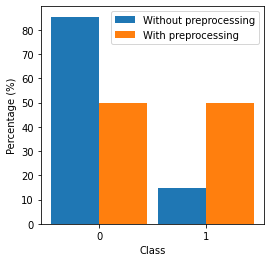

In [ ]:
# Computing classes distributions.
classes_without_upsampling, counts_without_upsampling = np.unique([item for sublist in df_train["changes"] for item in sublist], return_counts = True)
classes_with_upsampling, counts_with_upsampling = np.unique(train_labels, return_counts = True)

# Normalizing.
counts_without_upsampling = counts_without_upsampling / np.sum(counts_without_upsampling) * 100
counts_with_upsampling = counts_with_upsampling / np.sum(counts_with_upsampling) * 100

# Plot classes distribution.
plot_classes_distribution([classes_without_upsampling, classes_with_upsampling], [counts_without_upsampling, counts_with_upsampling], "subtask1_distribution")

## Models Definition and Training

In this section, we define all the $m_x^1$ models. Moreover, once defined, we train all the models using a total number of epochs of $2$, an initial learning rate of $5e$$-5$ and batch size of $16$. Lastly, we use a learning rate schedule to decrease the learning rate by $20\%$ after a specific number of mini-batches.

In [ ]:
# Training hyperparameters.
LR = 5e-5
BATCH_SIZE = 16
N_EPOCHS = 2

# Learning rate schedule hyperparameters.
N_DECREASE_LR = 5
LR_REDUCTION = 20

### $m_1^1$

In [ ]:
# List of layers.
layers = [tf.keras.layers.GlobalMaxPool1D()]

# Creating the model.
m1 = create_bert_model(TFAutoModel.from_pretrained(checkpoint), (MAX_LENGTH,), n_classes = 2, layers = layers)

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Summary.
m1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',    

In [ ]:
# Compiling.
m1.compile(optimizer = Adam(LR), loss = SparseCategoricalCrossentropy(from_logits = False), metrics = ["accuracy"])

# Callbacks.
callbacks = [LearningRateSchedule(m1, n = int(np.round(len(train_ids) / BATCH_SIZE / N_DECREASE_LR)), reduction = 20)]

# Fitting.
m1.fit({"input_ids": train_ids, "attention_masks": train_masks, "token_type_ids": train_type_ids}, train_labels, epochs = N_EPOCHS, batch_size = BATCH_SIZE, callbacks = callbacks)

Epoch 1/2


 374/1875 [====>.........................] - ETA: 21:11 - loss: 0.5984 - accuracy: 0.6741
The learning rate was adjusted from 5.0000e-05 to 4.0000e-05.
 749/1875 [==========>...................] - ETA: 16:07 - loss: 0.5455 - accuracy: 0.7129
The learning rate was adjusted from 4.0000e-05 to 3.2000e-05.
1124/1875 [================>.............] - ETA: 10:48 - loss: 0.5040 - accuracy: 0.7403
The learning rate was adjusted from 3.2000e-05 to 2.5600e-05.
1499/1875 [======================>.......] - ETA: 5:25 - loss: 0.4724 - accuracy: 0.7619
The learning rate was adjusted from 2.5600e-05 to 2.0480e-05.
1874/1875 [============================>.] - ETA: 0s - loss: 0.4429 - accuracy: 0.7796
The learning rate was adjusted from 2.0480e-05 to 1.6384e-05.
1875/1875 [==============================] - 1635s 867ms/step - loss: 0.4429 - accuracy: 0.7796
Epoch 2/2
 374/1875 [====>.........................] - ETA: 21:47 - loss: 0.1789 - accuracy: 0.9347
The learning rate was adjusted from 1.6384e-05 t

### $m_2^1$

In [ ]:
# List of layers.
layers = [tf.keras.layers.GlobalAveragePooling1D()]

# Creating the model.
m2 = create_bert_model(TFAutoModel.from_pretrained(checkpoint), (MAX_LENGTH,), n_classes = 2, layers = layers)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Summary.
m2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',  

In [ ]:
# Compiling.
m2.compile(optimizer = Adam(LR), loss = SparseCategoricalCrossentropy(from_logits = False), metrics = ["accuracy"])

# Callbacks.
callbacks = [LearningRateSchedule(m2, n = int(np.round(len(train_ids) / BATCH_SIZE / N_DECREASE_LR)), reduction = 20)]

# Fitting.
m2.fit({"input_ids": train_ids, "attention_masks": train_masks, "token_type_ids": train_type_ids}, train_labels, epochs = N_EPOCHS, batch_size = BATCH_SIZE, callbacks = callbacks)

Epoch 1/2


 374/1875 [====>.........................] - ETA: 22:13 - loss: 0.5903 - accuracy: 0.6678
The learning rate was adjusted from 5.0000e-05 to 4.0000e-05.
 749/1875 [==========>...................] - ETA: 16:43 - loss: 0.5314 - accuracy: 0.7145
The learning rate was adjusted from 4.0000e-05 to 3.2000e-05.
1124/1875 [================>.............] - ETA: 11:09 - loss: 0.4839 - accuracy: 0.7503
The learning rate was adjusted from 3.2000e-05 to 2.5600e-05.
1499/1875 [======================>.......] - ETA: 5:35 - loss: 0.4451 - accuracy: 0.7752
The learning rate was adjusted from 2.5600e-05 to 2.0480e-05.
1874/1875 [============================>.] - ETA: 0s - loss: 0.4107 - accuracy: 0.7965
The learning rate was adjusted from 2.0480e-05 to 1.6384e-05.
1875/1875 [==============================] - 1682s 892ms/step - loss: 0.4107 - accuracy: 0.7965
Epoch 2/2
 374/1875 [====>.........................] - ETA: 22:21 - loss: 0.1201 - accuracy: 0.9547
The learning rate was adjusted from 1.6384e-05 t

### $m_3^1$

In [ ]:
# List of layers.
layers = [tf.keras.layers.GlobalMaxPool1D(),
          tf.keras.layers.Dense(128, activation = "relu")]

# Creating the model.
m3 = create_bert_model(TFAutoModel.from_pretrained(checkpoint), (MAX_LENGTH,), n_classes = 2, layers = layers)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Summary.
m3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',  

In [ ]:
# Compiling.
m3.compile(optimizer = Adam(LR), loss = SparseCategoricalCrossentropy(from_logits = False), metrics = ["accuracy"])

# Callbacks.
callbacks = [LearningRateSchedule(m3, n = int(np.round(len(train_ids) / BATCH_SIZE / N_DECREASE_LR)), reduction = 20)]

# Fitting.
m3.fit({"input_ids": train_ids, "attention_masks": train_masks, "token_type_ids": train_type_ids}, train_labels, epochs = N_EPOCHS, batch_size = BATCH_SIZE, callbacks = callbacks)

Epoch 1/2


 374/1875 [====>.........................] - ETA: 21:28 - loss: 0.5914 - accuracy: 0.6758
The learning rate was adjusted from 5.0000e-05 to 4.0000e-05.
 749/1875 [==========>...................] - ETA: 16:10 - loss: 0.5393 - accuracy: 0.7134
The learning rate was adjusted from 4.0000e-05 to 3.2000e-05.
1124/1875 [================>.............] - ETA: 10:48 - loss: 0.4990 - accuracy: 0.7403
The learning rate was adjusted from 3.2000e-05 to 2.5600e-05.
1499/1875 [======================>.......] - ETA: 5:25 - loss: 0.4655 - accuracy: 0.7636
The learning rate was adjusted from 2.5600e-05 to 2.0480e-05.
1874/1875 [============================>.] - ETA: 0s - loss: 0.4343 - accuracy: 0.7831
The learning rate was adjusted from 2.0480e-05 to 1.6384e-05.
1875/1875 [==============================] - 1631s 865ms/step - loss: 0.4342 - accuracy: 0.7831
Epoch 2/2
 374/1875 [====>.........................] - ETA: 21:47 - loss: 0.1687 - accuracy: 0.9358
The learning rate was adjusted from 1.6384e-05 t

### $m_4^1$

In [ ]:
# List of layers.
layers = [tf.keras.layers.Conv1D(filters = 128, kernel_size = 3, activation = "relu"),
          tf.keras.layers.MaxPooling1D(pool_size = 2),
          tf.keras.layers.Conv1D(filters = 128, kernel_size = 3, activation = "relu"),
          tf.keras.layers.MaxPooling1D(pool_size = 2),
          tf.keras.layers.Conv1D(filters = 128, kernel_size = 3, activation = "relu"),
          tf.keras.layers.MaxPooling1D(pool_size = 2),
          tf.keras.layers.Flatten()]

# Creating the model.
m4 = create_bert_model(TFAutoModel.from_pretrained(checkpoint), (MAX_LENGTH,), n_classes = 2, layers = layers)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Summary.
m4.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model_3 (TFBertModel)  TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',  

In [ ]:
# Compiling.
m4.compile(optimizer = Adam(LR), loss = SparseCategoricalCrossentropy(from_logits = False), metrics = ["accuracy"])

# Callbacks.
callbacks = [LearningRateSchedule(m4, n = int(np.round(len(train_ids) / BATCH_SIZE / N_DECREASE_LR)), reduction = 20)]

# Fitting.
m4.fit({"input_ids": train_ids, "attention_masks": train_masks, "token_type_ids": train_type_ids}, train_labels, epochs = N_EPOCHS, batch_size = BATCH_SIZE, callbacks = callbacks)

Epoch 1/2


 374/1875 [====>.........................] - ETA: 22:15 - loss: 0.6173 - accuracy: 0.6347
The learning rate was adjusted from 5.0000e-05 to 4.0000e-05.
 749/1875 [==========>...................] - ETA: 16:45 - loss: 0.5673 - accuracy: 0.6806
The learning rate was adjusted from 4.0000e-05 to 3.2000e-05.
1124/1875 [================>.............] - ETA: 11:11 - loss: 0.5268 - accuracy: 0.7142
The learning rate was adjusted from 3.2000e-05 to 2.5600e-05.
1499/1875 [======================>.......] - ETA: 5:36 - loss: 0.4955 - accuracy: 0.7380
The learning rate was adjusted from 2.5600e-05 to 2.0480e-05.
1874/1875 [============================>.] - ETA: 0s - loss: 0.4648 - accuracy: 0.7592
The learning rate was adjusted from 2.0480e-05 to 1.6384e-05.
1875/1875 [==============================] - 1694s 895ms/step - loss: 0.4649 - accuracy: 0.7592
Epoch 2/2
 374/1875 [====>.........................] - ETA: 22:25 - loss: 0.2050 - accuracy: 0.9168
The learning rate was adjusted from 1.6384e-05 t

## Model Testing

The macro $F_1$-score for all the models is computed and printed.

### $m_1^1$

In [ ]:
# Validation test.
y_pred_m1 = np.argmax(m1.predict({"input_ids": valid_ids, "attention_masks": valid_masks, "token_type_ids": valid_type_ids}), axis = 1)

# Saving true and predicted labels.
np.save("subtask1_m1_pred.npy", y_pred_m1)
np.save("subtask1_m1_true.npy", valid_labels)

# Printing score.
print(classification_report(valid_labels, y_pred_m1))

67/67 [==============================] - 39s 521ms/step
              precision    recall  f1-score   support

           0       0.96      0.82      0.88      1841
           1       0.42      0.81      0.55       300

    accuracy                           0.82      2141
   macro avg       0.69      0.81      0.72      2141
weighted avg       0.89      0.82      0.84      2141



### $m_2^1$

In [ ]:
# Validation test.
y_pred_m2 = np.argmax(m2.predict({"input_ids": valid_ids, "attention_masks": valid_masks, "token_type_ids": valid_type_ids}), axis = 1)

# Saving true and predicted labels.
np.save("subtask1_m2_pred.npy", y_pred_m2)
np.save("subtask1_m2_true.npy", valid_labels)

# Printing score.
print(classification_report(valid_labels, y_pred_m2))

67/67 [==============================] - 38s 527ms/step
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      1841
           1       0.41      0.82      0.55       300

    accuracy                           0.81      2141
   macro avg       0.69      0.81      0.71      2141
weighted avg       0.89      0.81      0.83      2141



### $m_3^1$

In [ ]:
# Validation test.
y_pred_m3 = np.argmax(m3.predict({"input_ids": valid_ids, "attention_masks": valid_masks, "token_type_ids": valid_type_ids}), axis = 1)

# Saving true and predicted labels.
np.save("subtask1_m3_pred.npy", y_pred_m3)
np.save("subtask1_m3_true.npy", valid_labels)

# Printing score.
print(classification_report(valid_labels, y_pred_m3))

67/67 [==============================] - 38s 532ms/step
              precision    recall  f1-score   support

           0       0.97      0.80      0.88      1841
           1       0.40      0.82      0.54       300

    accuracy                           0.81      2141
   macro avg       0.69      0.81      0.71      2141
weighted avg       0.89      0.81      0.83      2141



### $m_4^1$

In [ ]:
# Validation test.
y_pred_m4 = np.argmax(m4.predict({"input_ids": valid_ids, "attention_masks": valid_masks, "token_type_ids": valid_type_ids}), axis = 1)

# Saving true and predicted labels.
np.save("subtask1_m4_pred.npy", y_pred_m4)
np.save("subtask1_m4_true.npy", valid_labels)

# Printing score.
print(classification_report(valid_labels, y_pred_m4))

67/67 [==============================] - 40s 543ms/step
              precision    recall  f1-score   support

           0       0.96      0.77      0.86      1841
           1       0.37      0.81      0.51       300

    accuracy                           0.78      2141
   macro avg       0.66      0.79      0.68      2141
weighted avg       0.88      0.78      0.81      2141



# Task 2

## Data Inspection

First, we create the $N \times 7$ dataframes that contains the `authors` (i.e. the total number of authors in the generic document), `site` (i.e. the source site from which the document was extracted), 
`multi-author` (i.e. a boolean flag indicating
whether the generic document has been written
by multiple authors), `changes` (i.e. a list of boolean
varibles determining changes between paragraphs
or sentences), `paragraph-authors` (i.e. a list of
integer variables that label each paragraph or sentence
with an author ID), `input_text` (i.e. the content
of the entire document) and `splitted_text` (i.e.
the list of paragraphs or sentences of the generic
document).

Then, for both the training and validation sets, we inspect the computed dataframes.

In [ ]:
train_directory = '/content/dataset2/train'
df_train = create_dataframe(train_directory)
df_train.head()

,authors,site,multi-author,changes,paragraph-authors,input_text,splitted_text
0,3,serverfault.com.7z,1,"[1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1]","[1, 2, 3, 2, 1, 2, 2, 1, 3, 3, 1, 1, 3]",Small Business Server (SBS) would seem to be a...,[Small Business Server (SBS) would seem to be ...
1,5,serverfault.com.7z,1,"[1, 1, 1, 1, 1, 1]","[1, 2, 3, 4, 5, 2, 3]",None of the suggested key combinations bring m...,[None of the suggested key combinations bring ...
2,5,superuser.com.7z,1,"[1, 0, 1, 1, 0, 1, 1, 1]","[1, 2, 2, 3, 2, 2, 4, 3, 5]","If you are using the ext3 filesystem, then ext...","[If you are using the ext3 filesystem, then ex..."
3,3,serverfault.com.7z,1,"[1, 1, 1, 0, 1]","[1, 2, 3, 1, 1, 2]","The sites are backed by a WCMS, so there is a ...","[The sites are backed by a WCMS, so there is a..."
4,1,serverfault.com.7z,0,"[0, 0, 0]","[1, 1, 1, 1]",I had a similar problem. I needed to delete a ...,[I had a similar problem. I needed to delete a...


In [ ]:
data_inspection(df_train)

Dataset size: (7000, 7)
Dataset columns: ['authors' 'site' 'multi-author' 'changes' 'paragraph-authors'
 'input_text' 'splitted_text']
Main sources: ['serverfault.com.7z' 'superuser.com.7z' 'cstheory.stackexchange.com.7z'
 'dba.stackexchange.com.7z' 'gamedev.stackexchange.com.7z'
 'datascience.stackexchange.com.7z'
 'networkengineering.stackexchange.com.7z'
 'codereview.stackexchange.com.7z' 'raspberrypi.stackexchange.com.7z'
 'cseducators.stackexchange.com.7z' 'devops.stackexchange.com.7z'
 'computergraphics.stackexchange.com.7z']
Number of questions per source:
 site
codereview.stackexchange.com.7z             241
computergraphics.stackexchange.com.7z        20
cseducators.stackexchange.com.7z             55
cstheory.stackexchange.com.7z                83
datascience.stackexchange.com.7z            118
dba.stackexchange.com.7z                    387
devops.stackexchange.com.7z                  23
gamedev.stackexchange.com.7z                528
networkengineering.stackexchange.com.7z 

In [ ]:
valid_directory = '/content/dataset2/validation'
df_valid = create_dataframe(valid_directory)
df_valid.head()

,authors,site,multi-author,changes,paragraph-authors,input_text,splitted_text
0,5,serverfault.com.7z,1,"[1, 0, 1, 1, 1]","[1, 2, 2, 3, 4, 5]",Force detach the system volume. Then you will...,[Force detach the system volume. Then you wil...
1,5,serverfault.com.7z,1,"[1, 1, 1, 1, 1, 1, 1, 1]","[1, 2, 3, 1, 4, 1, 4, 5, 4]","At any rate, I suspect that these applications...","[At any rate, I suspect that these application..."
2,1,serverfault.com.7z,0,"[0, 0]","[1, 1, 1]",I'm trying to understand the hype around cloud...,[I'm trying to understand the hype around clou...
3,1,cstheory.stackexchange.com.7z,0,[0],"[1, 1]","I think one issue is that we need to fix the ""...",[I think one issue is that we need to fix the ...
4,4,gamedev.stackexchange.com.7z,1,"[1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1]","[1, 2, 3, 1, 1, 1, 1, 3, 1, 3, 3, 2, 4, 2, 2, 1]",Keep in mind that AI/effects that happen on a ...,[Keep in mind that AI/effects that happen on a...


In [ ]:
data_inspection(df_valid)

Dataset size: (1500, 7)
Dataset columns: ['authors' 'site' 'multi-author' 'changes' 'paragraph-authors'
 'input_text' 'splitted_text']
Main sources: ['serverfault.com.7z' 'cstheory.stackexchange.com.7z'
 'gamedev.stackexchange.com.7z' 'superuser.com.7z'
 'dba.stackexchange.com.7z' 'devops.stackexchange.com.7z'
 'codereview.stackexchange.com.7z' 'datascience.stackexchange.com.7z'
 'networkengineering.stackexchange.com.7z'
 'raspberrypi.stackexchange.com.7z' 'cseducators.stackexchange.com.7z'
 'computergraphics.stackexchange.com.7z']
Number of questions per source:
 site
codereview.stackexchange.com.7z             56
computergraphics.stackexchange.com.7z        8
cseducators.stackexchange.com.7z             6
cstheory.stackexchange.com.7z               18
datascience.stackexchange.com.7z            40
dba.stackexchange.com.7z                    75
devops.stackexchange.com.7z                  6
gamedev.stackexchange.com.7z               118
networkengineering.stackexchange.com.7z     24
r

## Data preprocessing

We download the tokenizer that is used by the BERT model.

In [ ]:
# Model checkpoint.
checkpoint = "bert-base-cased"

# Getting tokenizer.
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Once the tokenizer is downloaded, we proceed by 1). preprocessing the input data by means of down-sampling so to balance the number of samples for the two possible classes, and by computing the following tensors: 

*   `train_ids`, i.e. the tensor that contains tokenized pairs of texts. Each sample is encoded as `[CLS] P/S-A [SEP] P/S-B [SEP]`, where `P/S-A` and `P/S-B` are the two passages of text, while `[CLS]` and `[SEP]` are the usual tokens used by the BERT tokenizer for defining the input tensors.

*   `train_labels`, i.e. the tensor that contains the true labels.

*   `train_masks`, i.e. the boolean tensor that is used to mask the input pairs, so to be able to discard the padding tokens while applying the attention mechanism. 

*   `train_type_ids`, i.e. the boolean tensor indicating which elements of the input tensor is related to `P/S-A` and which others are related to `P/S-B`.

In particular, the maximum length of the input tensor is set to `256`. Moreover, to be able to balance the number of the samples of both classes, we only use down-sampling by selecting a number of samples equal to `15000` for both classes.

In [ ]:
# Max input length.
MAX_LENGTH = 256

# Number of samples per class.
MAX_SAMPLES = 15000

# Splitting data.
train_ids, train_labels, train_masks, train_type_ids = preprocess_without_data_augmentation(df_train["splitted_text"].values, df_train["changes"].values, tokenizer, MAX_LENGTH, max_samples = MAX_SAMPLES)
valid_ids, valid_labels, valid_masks, valid_type_ids = preprocess_with_data_augmentation(df_valid["splitted_text"].values, df_valid["paragraph-authors"].values, tokenizer, MAX_LENGTH, total_upsampling = True)

# Printing shapes.
print(f"train_ids: {train_ids.shape}, train_labels: {train_labels.shape}, train_masks: {train_masks.shape}, train_type_ids: {train_type_ids.shape}.")
print(f"valid_ids: {valid_ids.shape}, valid_labels: {valid_labels.shape}, valid_masks: {valid_masks.shape}, valid_type_ids: {valid_type_ids.shape}.")

train_ids: (30000, 256), train_labels: (30000,), train_masks: (30000, 256), train_type_ids: (30000, 256).
valid_ids: (87862, 256), valid_labels: (87862,), valid_masks: (87862, 256), valid_type_ids: (87862, 256).


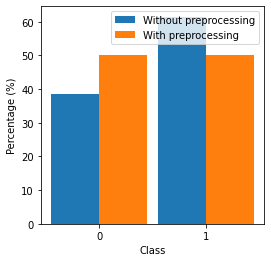

In [ ]:
# Computing classes distributions.
classes_without_upsampling, counts_without_upsampling = np.unique([item for sublist in df_train["changes"] for item in sublist], return_counts = True)
classes_with_upsampling, counts_with_upsampling = np.unique(train_labels, return_counts = True)

# Normalizing.
counts_without_upsampling = counts_without_upsampling / np.sum(counts_without_upsampling) * 100
counts_with_upsampling = counts_with_upsampling / np.sum(counts_with_upsampling) * 100

# Plot classes distribution.
plot_classes_distribution([classes_without_upsampling, classes_with_upsampling], [counts_without_upsampling, counts_with_upsampling], "subtask2_distribution")

## Models Definition and Training

In this section, we define all the $m_x^1$ models. Moreover, once defined, we train all the models using a total number of epochs of $2$, an initial learning rate of $5e$$-5$ and batch size of $16$. Lastly, we use a learning rate schedule to decrease the learning rate by $20\%$ after a specific number of mini-batches.

In [ ]:
# Training hyperparameters.
LR = 5e-5
BATCH_SIZE = 16
N_EPOCHS = 2

# Learning rate schedule hyperparameters.
N_DECREASE_LR = 5
LR_REDUCTION = 20

### $m_1^1$

In [ ]:
# List of layers.
layers = [tf.keras.layers.GlobalMaxPool1D()]

# Creating the model.
m11 = create_bert_model(TFAutoModel.from_pretrained(checkpoint), (MAX_LENGTH,), n_classes = 2, layers = layers)

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Summary.
m11.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',    

In [ ]:
# Compiling.
m11.compile(optimizer = Adam(LR), loss = SparseCategoricalCrossentropy(from_logits = False), metrics = ["accuracy"])

# Callbacks.
callbacks = [LearningRateSchedule(m11, n = int(np.round(len(train_ids) / BATCH_SIZE / N_DECREASE_LR)), reduction = 20)]

# Fitting.
m11.fit({"input_ids": train_ids, "attention_masks": train_masks, "token_type_ids": train_type_ids}, train_labels, epochs = N_EPOCHS, batch_size = BATCH_SIZE, callbacks = callbacks)

Epoch 1/2


 374/1875 [====>.........................] - ETA: 22:37 - loss: 0.6714 - accuracy: 0.6131
The learning rate was adjusted from 5.0000e-05 to 4.0000e-05.
 749/1875 [==========>...................] - ETA: 17:00 - loss: 0.6291 - accuracy: 0.6514
The learning rate was adjusted from 4.0000e-05 to 3.2000e-05.
1124/1875 [================>.............] - ETA: 11:21 - loss: 0.6348 - accuracy: 0.6386
The learning rate was adjusted from 3.2000e-05 to 2.5600e-05.
1499/1875 [======================>.......] - ETA: 5:41 - loss: 0.6524 - accuracy: 0.6058
The learning rate was adjusted from 2.5600e-05 to 2.0480e-05.
1874/1875 [============================>.] - ETA: 0s - loss: 0.6628 - accuracy: 0.5845
The learning rate was adjusted from 2.0480e-05 to 1.6384e-05.
1875/1875 [==============================] - 1713s 908ms/step - loss: 0.6628 - accuracy: 0.5844
Epoch 2/2
 374/1875 [====>.........................] - ETA: 22:44 - loss: 0.7001 - accuracy: 0.4985
The learning rate was adjusted from 1.6384e-05 t

### $m_2^1$

In [ ]:
# List of layers.
layers = [tf.keras.layers.GlobalAveragePooling1D()]

# Creating the model.
m22 = create_bert_model(TFAutoModel.from_pretrained(checkpoint), (MAX_LENGTH,), n_classes = 2, layers = layers)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Summary.
m22.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',  

In [ ]:
# Compiling.
m22.compile(optimizer = Adam(LR), loss = SparseCategoricalCrossentropy(from_logits = False), metrics = ["accuracy"])

# Callbacks.
callbacks = [LearningRateSchedule(m22, n = int(np.round(len(train_ids) / BATCH_SIZE / N_DECREASE_LR)), reduction = 20)]

# Fitting.
m22.fit({"input_ids": train_ids, "attention_masks": train_masks, "token_type_ids": train_type_ids}, train_labels, epochs = N_EPOCHS, batch_size = BATCH_SIZE, callbacks = callbacks)

Epoch 1/2


 374/1875 [====>.........................] - ETA: 23:18 - loss: 0.6540 - accuracy: 0.6103
The learning rate was adjusted from 5.0000e-05 to 4.0000e-05.
 749/1875 [==========>...................] - ETA: 17:29 - loss: 0.6169 - accuracy: 0.6525
The learning rate was adjusted from 4.0000e-05 to 3.2000e-05.
1124/1875 [================>.............] - ETA: 11:39 - loss: 0.5937 - accuracy: 0.6748
The learning rate was adjusted from 3.2000e-05 to 2.5600e-05.
1499/1875 [======================>.......] - ETA: 5:50 - loss: 0.5808 - accuracy: 0.6860
The learning rate was adjusted from 2.5600e-05 to 2.0480e-05.
1874/1875 [============================>.] - ETA: 0s - loss: 0.5690 - accuracy: 0.6952
The learning rate was adjusted from 2.0480e-05 to 1.6384e-05.
1875/1875 [==============================] - 1757s 932ms/step - loss: 0.5689 - accuracy: 0.6953
Epoch 2/2
 374/1875 [====>.........................] - ETA: 23:21 - loss: 0.3616 - accuracy: 0.8336
The learning rate was adjusted from 1.6384e-05 t

### $m_3^1$

In [ ]:
# List of layers.
layers = [tf.keras.layers.GlobalMaxPool1D(),
          tf.keras.layers.Dense(128, activation = "relu")]

# Creating the model.
m33 = create_bert_model(TFAutoModel.from_pretrained(checkpoint), (MAX_LENGTH,), n_classes = 2, layers = layers)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Summary.
m33.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',  

In [ ]:
# Compiling.
m33.compile(optimizer = Adam(LR), loss = SparseCategoricalCrossentropy(from_logits = False), metrics = ["accuracy"])

# Callbacks.
callbacks = [LearningRateSchedule(m33, n = int(np.round(len(train_ids) / BATCH_SIZE / N_DECREASE_LR)), reduction = 20)]

# Fitting.
m33.fit({"input_ids": train_ids, "attention_masks": train_masks, "token_type_ids": train_type_ids}, train_labels, epochs = N_EPOCHS, batch_size = BATCH_SIZE, callbacks = callbacks)

Epoch 1/2


 374/1875 [====>.........................] - ETA: 22:31 - loss: 0.6607 - accuracy: 0.6133
The learning rate was adjusted from 5.0000e-05 to 4.0000e-05.
 749/1875 [==========>...................] - ETA: 16:55 - loss: 0.6207 - accuracy: 0.6531
The learning rate was adjusted from 4.0000e-05 to 3.2000e-05.
1124/1875 [================>.............] - ETA: 11:17 - loss: 0.5956 - accuracy: 0.6769
The learning rate was adjusted from 3.2000e-05 to 2.5600e-05.
1499/1875 [======================>.......] - ETA: 5:39 - loss: 0.5836 - accuracy: 0.6874
The learning rate was adjusted from 2.5600e-05 to 2.0480e-05.
1874/1875 [============================>.] - ETA: 0s - loss: 0.5726 - accuracy: 0.6974
The learning rate was adjusted from 2.0480e-05 to 1.6384e-05.
1875/1875 [==============================] - 1701s 902ms/step - loss: 0.5725 - accuracy: 0.6975
Epoch 2/2
 374/1875 [====>.........................] - ETA: 22:31 - loss: 0.3865 - accuracy: 0.8264
The learning rate was adjusted from 1.6384e-05 t

### $m_4^1$

In [ ]:
# List of layers.
layers = [tf.keras.layers.Conv1D(filters = 128, kernel_size = 3, activation = "relu"),
          tf.keras.layers.MaxPooling1D(pool_size = 2),
          tf.keras.layers.Conv1D(filters = 128, kernel_size = 3, activation = "relu"),
          tf.keras.layers.MaxPooling1D(pool_size = 2),
          tf.keras.layers.Conv1D(filters = 128, kernel_size = 3, activation = "relu"),
          tf.keras.layers.MaxPooling1D(pool_size = 2),
          tf.keras.layers.Flatten()]

# Creating the model.
m44 = create_bert_model(TFAutoModel.from_pretrained(checkpoint), (MAX_LENGTH,), n_classes = 2, layers = layers)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Summary.
m44.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model_3 (TFBertModel)  TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',  

In [ ]:
# Compiling.
m44.compile(optimizer = Adam(LR), loss = SparseCategoricalCrossentropy(from_logits = False), metrics = ["accuracy"])

# Callbacks.
callbacks = [LearningRateSchedule(m44, n = int(np.round(len(train_ids) / BATCH_SIZE / N_DECREASE_LR)), reduction = 20)]

# Fitting.
m44.fit({"input_ids": train_ids, "attention_masks": train_masks, "token_type_ids": train_type_ids}, train_labels, epochs = N_EPOCHS, batch_size = BATCH_SIZE, callbacks = callbacks)

Epoch 1/2


 374/1875 [====>.........................] - ETA: 23:22 - loss: 0.6669 - accuracy: 0.5959
The learning rate was adjusted from 5.0000e-05 to 4.0000e-05.
 749/1875 [==========>...................] - ETA: 17:31 - loss: 0.6328 - accuracy: 0.6377
The learning rate was adjusted from 4.0000e-05 to 3.2000e-05.
1124/1875 [================>.............] - ETA: 11:41 - loss: 0.6137 - accuracy: 0.6569
The learning rate was adjusted from 3.2000e-05 to 2.5600e-05.
1499/1875 [======================>.......] - ETA: 5:50 - loss: 0.6015 - accuracy: 0.6671
The learning rate was adjusted from 2.5600e-05 to 2.0480e-05.
1874/1875 [============================>.] - ETA: 0s - loss: 0.5903 - accuracy: 0.6770
The learning rate was adjusted from 2.0480e-05 to 1.6384e-05.
1875/1875 [==============================] - 1765s 934ms/step - loss: 0.5902 - accuracy: 0.6770
Epoch 2/2
 374/1875 [====>.........................] - ETA: 23:23 - loss: 0.4341 - accuracy: 0.7941
The learning rate was adjusted from 1.6384e-05 t

## Model Testing

The macro $F_1$-score for all the models is computed and printed.

In [ ]:
# Computing uni-dimensional list of paragraph authors.
valid_labels = [author for authors in df_valid["paragraph-authors"].values for author in authors]

### $m_1^1$

In [ ]:
# Validation test.
y_pred_m11 = np.argmax(m11.predict({"input_ids": valid_ids, "attention_masks": valid_masks, "token_type_ids": valid_type_ids}), axis = 1)

# Casting y_pred to be list of paragraph-authors instead of list of changes.
y_pred_m11 = compute_authors_pred_list(df_valid["paragraph-authors"].values, y_pred_m11)

# Saving true and predicted labels.
np.save("subtask2_m1_pred.npy", y_pred_m11)
np.save("subtask2_m1_true.npy", valid_labels)

# Printing score.
print(classification_report(valid_labels, y_pred_m11))

2746/2746 [==============================] - 1569s 570ms/step
              precision    recall  f1-score   support

           1       1.00      0.29      0.45      5098
           2       0.57      0.30      0.39      2828
           3       0.29      0.25      0.27      1701
           4       0.12      0.18      0.15       978
           5       0.08      1.00      0.16       432

    accuracy                           0.31     11037
   macro avg       0.41      0.41      0.28     11037
weighted avg       0.67      0.31      0.37     11037



### $m_2^1$

In [ ]:
# Validation test.
y_pred_m22 = np.argmax(m22.predict({"input_ids": valid_ids, "attention_masks": valid_masks, "token_type_ids": valid_type_ids}), axis = 1)

# Casting y_pred to be list of paragraph-authors instead of list of changes.
y_pred_m22 = compute_authors_pred_list(df_valid["paragraph-authors"].values, y_pred_m22)

# Saving true and predicted labels.
np.save("subtask2_m2_pred.npy", y_pred_m22)
np.save("subtask2_m2_true.npy", valid_labels)

# Printing score.
print(classification_report(valid_labels, y_pred_m22))

2746/2746 [==============================] - 1650s 600ms/step
              precision    recall  f1-score   support

           1       0.74      0.83      0.79      5098
           2       0.59      0.58      0.59      2828
           3       0.42      0.36      0.39      1701
           4       0.31      0.21      0.25       978
           5       0.24      0.24      0.24       432

    accuracy                           0.62     11037
   macro avg       0.46      0.44      0.45     11037
weighted avg       0.60      0.62      0.60     11037



### $m_3^1$

In [ ]:
# Validation test.
y_pred_m33 = np.argmax(m33.predict({"input_ids": valid_ids, "attention_masks": valid_masks, "token_type_ids": valid_type_ids}), axis = 1)

# Casting y_pred to be list of paragraph-authors instead of list of changes.
y_pred_m33 = compute_authors_pred_list(df_valid["paragraph-authors"].values, y_pred_m33)

# Saving true and predicted labels.
np.save("subtask2_m3_pred.npy", y_pred_m33)
np.save("subtask2_m3_true.npy", valid_labels)

# Printing score.
print(classification_report(valid_labels, y_pred_m33))

2746/2746 [==============================] - 1649s 600ms/step
              precision    recall  f1-score   support

           1       0.72      0.86      0.78      5098
           2       0.58      0.56      0.57      2828
           3       0.41      0.32      0.36      1701
           4       0.35      0.21      0.26       978
           5       0.26      0.19      0.22       432

    accuracy                           0.61     11037
   macro avg       0.46      0.43      0.44     11037
weighted avg       0.58      0.61      0.59     11037



### $m_4^1$

In [ ]:
# Validation test.
y_pred_m44 = np.argmax(m44.predict({"input_ids": valid_ids, "attention_masks": valid_masks, "token_type_ids": valid_type_ids}), axis = 1)

# Casting y_pred to be list of paragraph-authors instead of list of changes.
y_pred_m44 = compute_authors_pred_list(df_valid["paragraph-authors"].values, y_pred_m44)

# Saving true and predicted labels.
np.save("subtask2_m4_pred.npy", y_pred_m44)
np.save("subtask2_m4_true.npy", valid_labels)

# Printing score.
print(classification_report(valid_labels, y_pred_m44))

2746/2746 [==============================] - 1641s 597ms/step
              precision    recall  f1-score   support

           1       0.72      0.84      0.78      5098
           2       0.58      0.56      0.57      2828
           3       0.41      0.34      0.37      1701
           4       0.33      0.19      0.24       978
           5       0.22      0.17      0.19       432

    accuracy                           0.61     11037
   macro avg       0.45      0.42      0.43     11037
weighted avg       0.58      0.61      0.59     11037



## Error Analysis

In this last section, we study how the performances of each architecture change with respect to the number of authors of the given documents

In [ ]:
# Loading saved outputs.
subtask2_m1_pred = np.load("subtask2_m1_pred.npy")
subtask2_m1_true = np.load("subtask2_m1_true.npy")
subtask2_m2_pred = np.load("subtask2_m2_pred.npy")
subtask2_m2_true = np.load("subtask2_m2_true.npy")
subtask2_m3_pred = np.load("subtask2_m3_pred.npy")
subtask2_m3_true = np.load("subtask2_m3_true.npy")
subtask2_m4_pred = np.load("subtask2_m4_pred.npy")
subtask2_m4_true = np.load("subtask2_m4_true.npy")

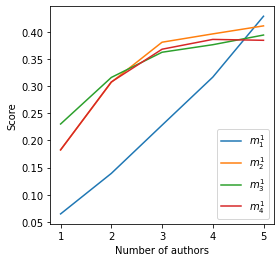

In [ ]:
# Computing scores wrt to number of authors.
f1 = []
f1.append(compute_score_wrt_authors(2, subtask2_m1_pred, subtask2_m1_true, df_valid))
f1.append(compute_score_wrt_authors(2, subtask2_m2_pred, subtask2_m2_true, df_valid))
f1.append(compute_score_wrt_authors(2, subtask2_m3_pred, subtask2_m3_true, df_valid))
f1.append(compute_score_wrt_authors(2, subtask2_m4_pred, subtask2_m4_true, df_valid))

# Plotting scores.
plot_score_wrt_authors(f1, "subtask2_error_analysis")

It is possible to notice how the performances of all models monotonically increase when the number of authors increase. However, the overall scores achieved by the $m_x^1$ models are not satisfactory, mainly due to the propagation of labeling errors during the application of the chosen labeling algorithm.

# Task 3


##Data Inspection

First, we create the $N \times 7$ dataframes that contains the `authors` (i.e. the total number of authors in the generic document), `site` (i.e. the source site from which the document was extracted), 
`multi-author` (i.e. a boolean flag indicating
whether the generic document has been written
by multiple authors), `changes` (i.e. a list of boolean
varibles determining changes between paragraphs
or sentences), `paragraph-authors` (i.e. a list of
integer variables that label each paragraph or sentence
with an author ID), `input_text` (i.e. the content
of the entire document) and `splitted_text` (i.e.
the list of paragraphs or sentences of the generic
document).

Then, for both the training and validation sets, we inspect the computed dataframes.

In [ ]:
train_directory = '/content/dataset3/train'
df_train = create_dataframe(train_directory)
df_train.head()

we have a problem at row:  1194


,authors,site,multi-author,changes,paragraph-authors,input_text,splitted_text
0,5,serverfault.com.7z,1,"[1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1]","[1, 2, 1, 1, 3, 2, 2, 3, 4, 5, 5, 2]",Everything else equals I would say it being mo...,[Everything else equals I would say it being m...
1,1,gamedev.stackexchange.com.7z,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",I also apologize for the lack of a 'decent' ti...,[I also apologize for the lack of a 'decent' t...
2,5,superuser.com.7z,1,"[1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1]","[1, 2, 3, 1, 1, 4, 5, 5, 1, 3, 3, 2, 2, 2, 1]",And updates should not need to touch /home/ an...,[And updates should not need to touch /home/ a...
3,1,computergraphics.stackexchange.com.7z,0,"[0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1]","But v1,v2,v4 and v5 would have non-zero normal...","[But v1,v2,v4 and v5 would have non-zero norma..."
4,3,superuser.com.7z,1,"[1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, ...","[1, 2, 1, 3, 2, 2, 3, 3, 2, 2, 1, 2, 2, 2, 3, ...",Now run this command to stop Windows from inst...,[Now run this command to stop Windows from ins...


In [ ]:
# Element at index 4 of df_train["splitted_text"][1194] is empty and needs to be removed.
del df_train["splitted_text"][1194][4]

In [ ]:
data_inspection(df_train)

Dataset size: (7000, 7)
Dataset columns: ['authors' 'site' 'multi-author' 'changes' 'paragraph-authors'
 'input_text' 'splitted_text']
Main sources: ['serverfault.com.7z' 'gamedev.stackexchange.com.7z' 'superuser.com.7z'
 'computergraphics.stackexchange.com.7z'
 'datascience.stackexchange.com.7z' 'codereview.stackexchange.com.7z'
 'cseducators.stackexchange.com.7z' 'raspberrypi.stackexchange.com.7z'
 'dba.stackexchange.com.7z' 'cstheory.stackexchange.com.7z'
 'networkengineering.stackexchange.com.7z' 'devops.stackexchange.com.7z']
Number of questions per source:
 site
codereview.stackexchange.com.7z             281
computergraphics.stackexchange.com.7z        23
cseducators.stackexchange.com.7z             57
cstheory.stackexchange.com.7z                97
datascience.stackexchange.com.7z            157
dba.stackexchange.com.7z                    352
devops.stackexchange.com.7z                  28
gamedev.stackexchange.com.7z                482
networkengineering.stackexchange.com.7z  

In [ ]:
valid_directory = '/content/dataset3/validation'
df_valid = create_dataframe(valid_directory)
df_valid.head()

,authors,site,multi-author,changes,paragraph-authors,input_text,splitted_text
0,4,serverfault.com.7z,1,"[1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1]","[1, 2, 1, 3, 3, 3, 1, 3, 4, 4, 1, 2, 3, 1, 1, 4]",And here is the question: why do I have to use...,[And here is the question: why do I have to us...
1,2,superuser.com.7z,1,"[1, 1, 1, 0, 0, 1, 0]","[1, 2, 1, 2, 2, 2, 1, 1]",Remove the Day column and combine the Date and...,[Remove the Day column and combine the Date an...
2,3,superuser.com.7z,1,"[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3, ...","(I will use the ""&"" to execute the command in ...","[(I will use the ""&"" to execute the command in..."
3,2,superuser.com.7z,1,"[1, 0, 0, 0, 1, 1, 0]","[1, 2, 2, 2, 2, 1, 2, 2]",In the advanced settings of openvpn i have cho...,[In the advanced settings of openvpn i have ch...
4,4,superuser.com.7z,1,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, ...","[1, 1, 2, 1, 3, 4, 1, 2, 3, 1, 1, 2, 1, 3, 1, ...",Every single device does not exceed the limit ...,[Every single device does not exceed the limit...


In [ ]:
data_inspection(df_valid)

Dataset size: (1500, 7)
Dataset columns: ['authors' 'site' 'multi-author' 'changes' 'paragraph-authors'
 'input_text' 'splitted_text']
Main sources: ['serverfault.com.7z' 'superuser.com.7z' 'dba.stackexchange.com.7z'
 'cstheory.stackexchange.com.7z' 'codereview.stackexchange.com.7z'
 'gamedev.stackexchange.com.7z' 'computergraphics.stackexchange.com.7z'
 'raspberrypi.stackexchange.com.7z'
 'networkengineering.stackexchange.com.7z'
 'cseducators.stackexchange.com.7z' 'datascience.stackexchange.com.7z'
 'devops.stackexchange.com.7z']
Number of questions per source:
 site
codereview.stackexchange.com.7z             50
computergraphics.stackexchange.com.7z        4
cseducators.stackexchange.com.7z             8
cstheory.stackexchange.com.7z               17
datascience.stackexchange.com.7z            22
dba.stackexchange.com.7z                    86
devops.stackexchange.com.7z                  6
gamedev.stackexchange.com.7z                92
networkengineering.stackexchange.com.7z     34
r

## Data Preprocessing

We download the tokenizer that is used by the BERT model.

In [ ]:
# Model checkpoint.
checkpoint = "bert-base-cased"

# Getting tokenizer.
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Once the tokenizer is downloaded, we proceed by 1). preprocessing the input data by means of down-sampling so to balance the number of samples for the two possible classes, and by computing the following tensors: 

*   `train_ids`, i.e. the tensor that contains tokenized pairs of texts. Each sample is encoded as `[CLS] P/S-A [SEP] P/S-B [SEP]`, where `P/S-A` and `P/S-B` are the two passages of text, while `[CLS]` and `[SEP]` are the usual tokens used by the BERT tokenizer for defining the input tensors.

*   `train_labels`, i.e. the tensor that contains the true labels.

*   `train_masks`, i.e. the boolean tensor that is used to mask the input pairs, so to be able to discard the padding tokens while applying the attention mechanism. 

*   `train_type_ids`, i.e. the boolean tensor indicating which elements of the input tensor is related to `P/S-A` and which others are related to `P/S-B`.

In particular, the maximum length of the input tensor is set to `64`. Moreover, to be able to balance the number of the samples of both classes, we only use down-sampling by selecting a number of samples equal to `15000` for both classes.

In [ ]:
# Max input length.
MAX_LENGTH = 64

# Number of samples per class.
MAX_SAMPLES = 15000

# Splitting data.
train_ids, train_labels, train_masks, train_type_ids = preprocess_without_data_augmentation(df_train["splitted_text"].values, df_train["changes"].values, tokenizer, MAX_LENGTH, max_samples = MAX_SAMPLES)
valid_ids, valid_labels, valid_masks, valid_type_ids = preprocess_without_data_augmentation(df_valid["splitted_text"].values, df_valid["changes"].values, tokenizer, MAX_LENGTH)

# Printing shapes.
print(f"train_ids: {train_ids.shape}, train_labels: {train_labels.shape}, train_masks: {train_masks.shape}, train_type_ids: {train_type_ids.shape}.")
print(f"valid_ids: {valid_ids.shape}, valid_labels: {valid_labels.shape}, valid_masks: {valid_masks.shape}, valid_type_ids: {valid_type_ids.shape}.")

train_ids: (30000, 64), train_labels: (30000,), train_masks: (30000, 64), train_type_ids: (30000, 64).
valid_ids: (22105, 64), valid_labels: (22105,), valid_masks: (22105, 64), valid_type_ids: (22105, 64).


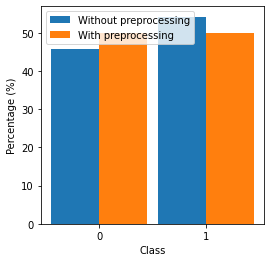

In [ ]:
# Computing classes distributions.
classes_without_upsampling, counts_without_upsampling = np.unique([item for sublist in df_train["changes"] for item in sublist], return_counts = True)
classes_with_upsampling, counts_with_upsampling = np.unique(train_labels, return_counts = True)

# Normalizing.
counts_without_upsampling = counts_without_upsampling / np.sum(counts_without_upsampling) * 100
counts_with_upsampling = counts_with_upsampling / np.sum(counts_with_upsampling) * 100

# Plot classes distribution.
plot_classes_distribution([classes_without_upsampling, classes_with_upsampling], [counts_without_upsampling, counts_with_upsampling], "subtask3_distribution")

## Models Definition and Training

In this section, we define all the $m_x^1$ models. Moreover, once defined, we train all the models using a total number of epochs of $2$, an initial learning rate of $5e$$-5$ and batch size of $16$. Lastly, we use a learning rate schedule to decrease the learning rate by $20\%$ after a specific number of mini-batches.

In [ ]:
# Training hyperparameters.
LR = 5e-5
BATCH_SIZE = 16
N_EPOCHS = 2

# Learning rate schedule hyperparameters.
N_DECREASE_LR = 5
LR_REDUCTION = 20

### $m_1^1$

In [ ]:
# List of layers.
layers = [tf.keras.layers.GlobalMaxPool1D()]

# Creating the model.
m111 = create_bert_model(TFAutoModel.from_pretrained(checkpoint), (MAX_LENGTH,), n_classes = 2, layers = layers)

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Summary.
m111.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 64)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 64)]         0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 64)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',    

In [ ]:
# Compiling.
m111.compile(optimizer = Adam(LR), loss = SparseCategoricalCrossentropy(from_logits = False), metrics = ["accuracy"])

# Callbacks.
callbacks = [LearningRateSchedule(m111, n = int(np.round(len(train_ids) / BATCH_SIZE / N_DECREASE_LR)), reduction = 20)]

# Fitting.
m111.fit({"input_ids": train_ids, "attention_masks": train_masks, "token_type_ids": train_type_ids}, train_labels, epochs = N_EPOCHS, batch_size = BATCH_SIZE, callbacks = callbacks)

Epoch 1/2


 374/1875 [====>.........................] - ETA: 6:07 - loss: 0.6982 - accuracy: 0.5717
The learning rate was adjusted from 5.0000e-05 to 4.0000e-05.
 749/1875 [==========>...................] - ETA: 4:36 - loss: 0.6823 - accuracy: 0.5868
The learning rate was adjusted from 4.0000e-05 to 3.2000e-05.
1124/1875 [================>.............] - ETA: 3:05 - loss: 0.6710 - accuracy: 0.5992
The learning rate was adjusted from 3.2000e-05 to 2.5600e-05.
1499/1875 [======================>.......] - ETA: 1:32 - loss: 0.6621 - accuracy: 0.6063
The learning rate was adjusted from 2.5600e-05 to 2.0480e-05.
1874/1875 [============================>.] - ETA: 0s - loss: 0.6547 - accuracy: 0.6140
The learning rate was adjusted from 2.0480e-05 to 1.6384e-05.
1875/1875 [==============================] - 472s 246ms/step - loss: 0.6546 - accuracy: 0.6140
Epoch 2/2
 374/1875 [====>.........................] - ETA: 6:06 - loss: 0.5256 - accuracy: 0.7385
The learning rate was adjusted from 1.6384e-05 to 1.3

### $m_2^1$

In [ ]:
# List of layers.
layers = [tf.keras.layers.GlobalAveragePooling1D()]

# Creating the model.
m222 = create_bert_model(TFAutoModel.from_pretrained(checkpoint), (MAX_LENGTH,), n_classes = 2, layers = layers)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Summary.
m222.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 64)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 64)]         0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 64)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',  

In [ ]:
# Compiling.
m222.compile(optimizer = Adam(LR), loss = SparseCategoricalCrossentropy(from_logits = False), metrics = ["accuracy"])

# Callbacks.
callbacks = [LearningRateSchedule(m222, n = int(np.round(len(train_ids) / BATCH_SIZE / N_DECREASE_LR)), reduction = 20)]

# Fitting.
m222.fit({"input_ids": train_ids, "attention_masks": train_masks, "token_type_ids": train_type_ids}, train_labels, epochs = N_EPOCHS, batch_size = BATCH_SIZE, callbacks = callbacks)

Epoch 1/2


 374/1875 [====>.........................] - ETA: 6:05 - loss: 0.6898 - accuracy: 0.5623
The learning rate was adjusted from 5.0000e-05 to 4.0000e-05.
 749/1875 [==========>...................] - ETA: 4:34 - loss: 0.6720 - accuracy: 0.5864
The learning rate was adjusted from 4.0000e-05 to 3.2000e-05.
1124/1875 [================>.............] - ETA: 3:03 - loss: 0.6620 - accuracy: 0.6014
The learning rate was adjusted from 3.2000e-05 to 2.5600e-05.
1499/1875 [======================>.......] - ETA: 1:31 - loss: 0.6559 - accuracy: 0.6082
The learning rate was adjusted from 2.5600e-05 to 2.0480e-05.
1874/1875 [============================>.] - ETA: 0s - loss: 0.6497 - accuracy: 0.6155
The learning rate was adjusted from 2.0480e-05 to 1.6384e-05.
1875/1875 [==============================] - 466s 244ms/step - loss: 0.6496 - accuracy: 0.6155
Epoch 2/2
 374/1875 [====>.........................] - ETA: 6:05 - loss: 0.5416 - accuracy: 0.7213
The learning rate was adjusted from 1.6384e-05 to 1.3

### $m_3^1$

In [ ]:
# List of layers.
layers = [tf.keras.layers.GlobalMaxPool1D(),
          tf.keras.layers.Dense(128, activation = "relu")]

# Creating the model.
m333 = create_bert_model(TFAutoModel.from_pretrained(checkpoint), (MAX_LENGTH,), n_classes = 2, layers = layers)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Summary.
m333.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 64)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 64)]         0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 64)]         0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',  

In [ ]:
# Compiling.
m333.compile(optimizer = Adam(LR), loss = SparseCategoricalCrossentropy(from_logits = False), metrics = ["accuracy"])

# Callbacks.
callbacks = [LearningRateSchedule(m333, n = int(np.round(len(train_ids) / BATCH_SIZE / N_DECREASE_LR)), reduction = 20)]

# Fitting.
m333.fit({"input_ids": train_ids, "attention_masks": train_masks, "token_type_ids": train_type_ids}, train_labels, epochs = N_EPOCHS, batch_size = BATCH_SIZE, callbacks = callbacks)

Epoch 1/2


 374/1875 [====>.........................] - ETA: 6:05 - loss: 0.6851 - accuracy: 0.5777
The learning rate was adjusted from 5.0000e-05 to 4.0000e-05.
 749/1875 [==========>...................] - ETA: 4:34 - loss: 0.6732 - accuracy: 0.5890
The learning rate was adjusted from 4.0000e-05 to 3.2000e-05.
1124/1875 [================>.............] - ETA: 3:02 - loss: 0.6595 - accuracy: 0.6051
The learning rate was adjusted from 3.2000e-05 to 2.5600e-05.
1499/1875 [======================>.......] - ETA: 1:31 - loss: 0.6510 - accuracy: 0.6130
The learning rate was adjusted from 2.5600e-05 to 2.0480e-05.
1874/1875 [============================>.] - ETA: 0s - loss: 0.6438 - accuracy: 0.6219
The learning rate was adjusted from 2.0480e-05 to 1.6384e-05.
1875/1875 [==============================] - 466s 244ms/step - loss: 0.6438 - accuracy: 0.6220
Epoch 2/2
 374/1875 [====>.........................] - ETA: 6:05 - loss: 0.5101 - accuracy: 0.7503
The learning rate was adjusted from 1.6384e-05 to 1.3

### $m_4^1$

In [ ]:
# List of layers.
layers = [tf.keras.layers.Conv1D(filters = 128, kernel_size = 3, activation = "relu"),
          tf.keras.layers.MaxPooling1D(pool_size = 2),
          tf.keras.layers.Conv1D(filters = 128, kernel_size = 3, activation = "relu"),
          tf.keras.layers.MaxPooling1D(pool_size = 2),
          tf.keras.layers.Conv1D(filters = 128, kernel_size = 3, activation = "relu"),
          tf.keras.layers.MaxPooling1D(pool_size = 2),
          tf.keras.layers.Flatten()]

# Creating the model.
m444 = create_bert_model(TFAutoModel.from_pretrained(checkpoint), (MAX_LENGTH,), n_classes = 2, layers = layers)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Summary.
m444.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 64)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 64)]         0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 64)]         0           []                               
                                                                                                  
 tf_bert_model_3 (TFBertModel)  TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',  

In [ ]:
# Compiling.
m444.compile(optimizer = Adam(LR), loss = SparseCategoricalCrossentropy(from_logits = False), metrics = ["accuracy"])

# Callbacks.
callbacks = [LearningRateSchedule(m444, n = int(np.round(len(train_ids) / BATCH_SIZE / N_DECREASE_LR)), reduction = 20)]

# Fitting.
m444.fit({"input_ids": train_ids, "attention_masks": train_masks, "token_type_ids": train_type_ids}, train_labels, epochs = N_EPOCHS, batch_size = BATCH_SIZE, callbacks = callbacks)

Epoch 1/2


 374/1875 [====>.........................] - ETA: 6:07 - loss: 0.6918 - accuracy: 0.5343
The learning rate was adjusted from 5.0000e-05 to 4.0000e-05.
 749/1875 [==========>...................] - ETA: 4:35 - loss: 0.6781 - accuracy: 0.5687
The learning rate was adjusted from 4.0000e-05 to 3.2000e-05.
1124/1875 [================>.............] - ETA: 3:03 - loss: 0.6676 - accuracy: 0.5865
The learning rate was adjusted from 3.2000e-05 to 2.5600e-05.
1499/1875 [======================>.......] - ETA: 1:31 - loss: 0.6604 - accuracy: 0.5976
The learning rate was adjusted from 2.5600e-05 to 2.0480e-05.
1874/1875 [============================>.] - ETA: 0s - loss: 0.6533 - accuracy: 0.6066
The learning rate was adjusted from 2.0480e-05 to 1.6384e-05.
1875/1875 [==============================] - 473s 245ms/step - loss: 0.6533 - accuracy: 0.6067
Epoch 2/2
 374/1875 [====>.........................] - ETA: 6:06 - loss: 0.5492 - accuracy: 0.7091
The learning rate was adjusted from 1.6384e-05 to 1.3

## Model Testing

The macro $F_1$-score for all the models is computed and printed.

### $m_1^1$

In [ ]:
# Validation test.
y_pred_m111 = np.argmax(m111.predict({"input_ids": valid_ids, "attention_masks": valid_masks, "token_type_ids": valid_type_ids}), axis = 1)

# Saving true and predicted labels.
np.save("subtask3_m1_pred.npy", y_pred_m111)
np.save("subtask3_m1_true.npy", valid_labels)

# Printing score.
print(classification_report(valid_labels, y_pred_m111))

691/691 [==============================] - 98s 138ms/step
              precision    recall  f1-score   support

           0       0.62      0.67      0.64     10043
           1       0.71      0.66      0.68     12062

    accuracy                           0.66     22105
   macro avg       0.66      0.66      0.66     22105
weighted avg       0.67      0.66      0.66     22105



### $m_2^1$

In [ ]:
# Validation test.
y_pred_m222 = np.argmax(m222.predict({"input_ids": valid_ids, "attention_masks": valid_masks, "token_type_ids": valid_type_ids}), axis = 1)

# Saving true and predicted labels.
np.save("subtask3_m2_pred.npy", y_pred_m222)
np.save("subtask3_m2_true.npy", valid_labels)

# Printing score.
print(classification_report(valid_labels, y_pred_m222))

691/691 [==============================] - 100s 141ms/step
              precision    recall  f1-score   support

           0       0.61      0.69      0.65     10043
           1       0.71      0.63      0.67     12062

    accuracy                           0.66     22105
   macro avg       0.66      0.66      0.66     22105
weighted avg       0.66      0.66      0.66     22105



### $m_3^1$

In [ ]:
# Validation test.
y_pred_m333 = np.argmax(m333.predict({"input_ids": valid_ids, "attention_masks": valid_masks, "token_type_ids": valid_type_ids}), axis = 1)

# Saving true and predicted labels.
np.save("subtask3_m3_pred.npy", y_pred_m333)
np.save("subtask3_m3_true.npy", valid_labels)

# Printing score.
print(classification_report(valid_labels, y_pred_m333))

691/691 [==============================] - 101s 142ms/step
              precision    recall  f1-score   support

           0       0.62      0.68      0.65     10043
           1       0.71      0.66      0.68     12062

    accuracy                           0.67     22105
   macro avg       0.67      0.67      0.66     22105
weighted avg       0.67      0.67      0.67     22105



### $m_4^1$

In [ ]:
# Validation test.
y_pred_m444 = np.argmax(m444.predict({"input_ids": valid_ids, "attention_masks": valid_masks, "token_type_ids": valid_type_ids}), axis = 1)

# Saving true and predicted labels.
np.save("subtask3_m4_pred.npy", y_pred_m444)
np.save("subtask3_m4_true.npy", valid_labels)

# Printing score.
print(classification_report(valid_labels, y_pred_m444))

691/691 [==============================] - 104s 145ms/step
              precision    recall  f1-score   support

           0       0.62      0.66      0.64     10043
           1       0.70      0.66      0.68     12062

    accuracy                           0.66     22105
   macro avg       0.66      0.66      0.66     22105
weighted avg       0.66      0.66      0.66     22105



## Error Analysis

In this last section, we study how the performances of each architecture change with respect to the number of authors of the given documents

In [ ]:
# Loading saved outputs.
subtask3_m1_pred = np.load("subtask3_m1_pred.npy")
subtask3_m1_true = np.load("subtask3_m1_true.npy")
subtask3_m2_pred = np.load("subtask3_m2_pred.npy")
subtask3_m2_true = np.load("subtask3_m2_true.npy")
subtask3_m3_pred = np.load("subtask3_m3_pred.npy")
subtask3_m3_true = np.load("subtask3_m3_true.npy")
subtask3_m4_pred = np.load("subtask3_m4_pred.npy")
subtask3_m4_true = np.load("subtask3_m4_true.npy")

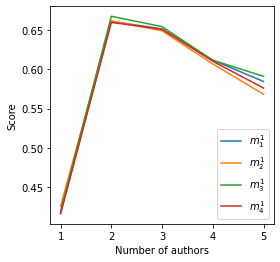

In [ ]:
# Computing scores wrt to number of authors.
f1 = []
f1.append(compute_score_wrt_authors(3, subtask3_m1_pred, subtask3_m1_true, df_valid))
f1.append(compute_score_wrt_authors(3, subtask3_m2_pred, subtask3_m2_true, df_valid))
f1.append(compute_score_wrt_authors(3, subtask3_m3_pred, subtask3_m3_true, df_valid))
f1.append(compute_score_wrt_authors(3, subtask3_m4_pred, subtask3_m4_true, df_valid))

# Plotting scores.
plot_score_wrt_authors(f1, "subtask3_error_analysis")

It is possible to notice how the scores achieved by all the models peak when the total number of authors is equal to $2$, and then decrease following a monotonic tren.

Overall, the macro $F_1$-scores computed on this third task are adequate, and almost reach the current state-of-the-art.

# References <a name="references"></a>

1. Eva Zangerle, Maximilian Mayerl, Martin Potthast, and Benno Stein. 2022. [https://pan.webis.de/clef22/pan22-web/style-change-detection.html](https://pan.webis.de/clef22/pan22-web/style-change-detection.html).